In [1]:
import tensorflow as tf
msg = tf.constant('Hello, TensorFlow!')
tf.print(msg)

Hello, TensorFlow!


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
import random
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageEnhance
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import time
from numpy.core.numeric import False_ 
from astropy.visualization import make_lupton_rgb
from matplotlib import pyplot

print("GPU is","avaliable" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is avaliable


In [4]:
print("tensorflow version:",tf.__version__)
print("GPU is","avaliable" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

tensorflow version: 2.5.0
GPU is avaliable


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
print("GPU is","avaliable" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is avaliable


In [7]:
# %% [markdown]
# # Data pre-processing
#parameter about input feature
item = ["HR", "O2Sat", "Temp", "SBP", "MAP", "Resp"] 
bound = [[30, 200], 
         [80, 100], 
         [35, 39], 
         [60, 180], 
         [60, 130], 
         [10, 35] 
        ] 
lower_bound=0 
upper_bound=1

#parameter about how many window we want to cut in one person data
random_times=10

#neural network set
tmpData = []
tmpDataR = [] 
tmpDataG = [] 
tmpDataB = [] 
tmpLabel = []
channel=3

window_size=10
check_size=1

#RGB g setup
r_mu=255.0
g_mu=128.0
b_mu=0.0
r_sigma=100.0
g_sigma=100.0
b_sigma=100.0

In [8]:

def rule(_label,check_begin,check_end,_window_size,_check_size):
    spesis=np.nanmean(_label)
    a=0
    if _label[0:_window_size-1].all()==0:
        check=dataframe["SepsisLabel"].iloc[check_begin:check_end].to_numpy()
        if np.nanmean(check)==0:
            # no sepsis : No sepsis across (window_size) hours period and next (check_size) hour
            outlabel= 0
        else:
            # pre-sepsis 1 : No sepsis across (window_size) hours period & sepsis in (window_size+1)~(window_size+check_size) hour
            outlabel=1
    elif np.nanmean(_label[0:int(window_size/2)])==0 and _label[_window_size-1]==1:
#         pre-sepsis 2 : No sepsis across (window_size/2) hours period & sepsis in number (window_size) hour
        outlabel = 1
    if spesis>=((_window_size/_window_size)/_window_size):
        # spesis : first hour and last hour are both spesis & total spesis time > 5
        outlabel = 2
#     print(_label,check,outlabel)
    return outlabel

In [9]:
#  window               #check      #label
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0] 0
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0] 0
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0] 0
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0] 0
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0] 0
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0] 0
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 0 1] 1
# [0 0 0 0 0 0 0 0 0 0] [0 0 0 1 1] 1
# [0 0 0 0 0 0 0 0 0 0] [0 0 1 1 1] 1
# [0 0 0 0 0 0 0 0 0 0] [0 1 1 1 1] 1
# [0 0 0 0 0 0 0 0 0 0] [1 1 1 1 1] 1
# [0 0 0 0 0 0 0 0 0  
# [0 0 0 0 0 1 1 1 1 1] [1 1 1 1 1] 2
# [0 0 0 0 1 1 1 1 1 1] [1 1 1 1] 2
# [0 0 0 1 1 1 1 1 1 1] [1 1 1] 2
# [0 0 1 1 1 1 1 1 1 1] [1 1] 2
# [0 1 1 1 1 1 1 1 1 1] [1] 2


#  data *= 255  # 变换为0-255的灰度值
#                     image = Image.fromarray(make_lupton_rgb(rdata.T, gdata.T, bdata.T, stretch=0.5)).resize((128,128))
#                     #R channel
#                     im_R = Image.fromarray(rdata.T).convert('L').resize((128,128))
#                     tmpData.append(np.array(im_R))
#                     #G channel
#                     im_G = Image.fromarray(gdata.T).convert('L').resize((128,128))
#                     tmpData.append(np.array(im_G))
#                     #B channel
#                     im_B = Image.fromarray(bdata.T).convert('L').resize((128,128))
#                     tmpData.append(np.array(im_B))
#                     #Gray channel
#                     im = Image.fromarray(data.T).convert('L') # 这样才能转为灰度图，如果是彩色图则改L为‘RGB’
#                     im = ImageEnhance.Contrast(im).enhance(5.5).resize((128,128))#ImageEnhance.Contrast(im).enhance(0)
# #                     tmpData.append(np.array(im))
#  #Change to graph and enhance it, than save feature graph to training set
#                     data *= 255  # 变换为0-255的灰度值
#                     im = Image.fromarray(data.T).convert('L') # 这样才能转为灰度图，如果是彩色图则改L为‘RGB’
#                     im = ImageEnhance.Contrast(im).enhance(5.5).resize((128,128))#ImageEnhance.Contrast(im).enhance(0)
#                     savepath="./out/"+str(classify)+"/"+filename+str(index)+".jpg"
#                     index+=1
#                     image.save(savepath)

In [10]:
def gus(x,mu,sigma):
    return math.exp(-((x-mu)*(x-mu))/(2*(sigma)*(sigma)))

In [11]:
# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-06-27T14:51:17.189751Z","iopub.execute_input":"2021-06-27T14:51:17.190388Z","iopub.status.idle":"2021-06-27T14:53:59.332797Z","shell.execute_reply.started":"2021-06-27T14:51:17.190334Z","shell.execute_reply":"2021-06-27T14:53:59.332019Z"}}
tStart = time.time()
import shutil
shutil.rmtree('./out/0')
os.mkdir('./out/0')
shutil.rmtree('./out/1')
os.mkdir('./out/1')
shutil.rmtree('./out/2')
os.mkdir('./out/2')
for file in range(1, 8000):
    #Read data
    #training_set data filename
    num = "%06d" % file
    filename = "p"+num
    ##training_setB data filename
    #num=100000+i
    #filename = "p"+str(num)
    index=0
    try:
#     if 1:
        dataframe = pd.read_csv("./training/"+filename+".psv", skiprows=0, sep='|') 
        print(filename)
        #Random cut method
        index=0
        for sample_time in range(random_times):
            leng = len(dataframe)-window_size
            up = random.randint(1, leng)
            
            #setup label 
            label = dataframe["SepsisLabel"].iloc[up:up+window_size].to_numpy()   
            a=rule(label,up+window_size,up+window_size+check_size,window_size,check_size)
            if random.randint(0,20)<=10:
                continue
            classify=rule(label,sample_time+window_size,sample_time+window_size+check_size,window_size,check_size)
            tmpLabel.append(classify)
                    
            #fill nan value and make dataframe(actually is numpy array)
            data= np.empty((window_size))
            rdata= np.empty((window_size))
            gdata= np.empty((window_size))
            bdata= np.empty((window_size))
            for items in range(len(item)):
                dataFromDF = dataframe[item[items]].drop(index=0).fillna(method='ffill').fillna(method='bfill')
                dataFromDF = dataFromDF.iloc[up-1:up+window_size-1] #??????
                dataFromDF = np.array((dataFromDF - bound[items][lower_bound])/(bound[items][upper_bound] - bound[items][lower_bound]))
                R_dataFromDF = 255*np.exp(-((255*dataFromDF-r_mu)*(255*dataFromDF-r_mu))/(2*(r_sigma)*(r_sigma)))  
                G_dataFromDF = 255*np.exp(-((255*dataFromDF-g_mu)*(255*dataFromDF-g_mu))/(2*(r_sigma)*(g_sigma)))  
                B_dataFromDF = 255*np.exp(-((255*dataFromDF-b_mu)*(255*dataFromDF-b_mu))/(2*(r_sigma)*(b_sigma)))  
                if items==0:
                    data=dataFromDF
                    rdata=R_dataFromDF
                    gdata=G_dataFromDF
                    bdata=B_dataFromDF
                else:
                    data=np.vstack([data,dataFromDF])
                    rdata=np.vstack([rdata,R_dataFromDF])
                    gdata=np.vstack([gdata,G_dataFromDF])
                    bdata=np.vstack([bdata,B_dataFromDF])
            
            #Change to graph and enhance it, than save feature graph to training set
            data *= 255  # 变换为0-255的灰度值
            image = Image.fromarray(make_lupton_rgb(rdata.T, gdata.T, bdata.T, stretch=0.5)).resize((128,128))
            image=ImageEnhance.Contrast(image).enhance(5.5)
#             im = Image.fromarray(data.T).convert('L') # 这样才能转为灰度图，如果是彩色图则改L为‘RGB’
#             im = ImageEnhance.Contrast(im).enhance(5.5).resize((128,128))#ImageEnhance.Contrast(im).enhance(0)
            tmpData.append(np.array(image))
#             print("1",np.array(tmpData).shape)
#             savepath="./out/"+str(classify)+"/"+filename+str(index)+".jpg"
#             image.save(savepath)
#             index+=1

        # from buttom to half data len 
        # because number of label 0 is about 90% of all data when random cut method  
        for sample_time in range(0,len(dataframe)-window_size): #int(len(dataframe)/2)-window_size
            if sample_time>0:
                #setup label (1,2)
                label = dataframe["SepsisLabel"].iloc[sample_time:sample_time+window_size].to_numpy()   
                check=dataframe["SepsisLabel"].iloc[sample_time+window_size:sample_time+window_size+5].to_numpy()
                if np.nanmean(check)>0  :
                    classify=rule(label,sample_time+window_size,sample_time+window_size+check_size,window_size,check_size)
                    tmpLabel.append(classify)
                    #fill nan value and make dataframe(actually is numpy array)
                    data= np.empty((window_size))
                    rdata= np.empty((window_size))
                    gdata= np.empty((window_size))
                    bdata= np.empty((window_size))
                    for items in range(len(item)):
                        dataFromDF = dataframe[item[items]].drop(index=0).fillna(method='ffill').fillna(method='bfill')
                        dataFromDF = dataFromDF.iloc[sample_time:sample_time+window_size]
                        dataFromDF = np.array((dataFromDF - bound[items][lower_bound])/(bound[items][upper_bound] - bound[items][lower_bound]))
                        R_dataFromDF = 255*np.exp(-((255*dataFromDF-r_mu)*(255*dataFromDF-r_mu))/(2*(r_sigma)*(r_sigma)))  
                        G_dataFromDF = 255*np.exp(-((255*dataFromDF-g_mu)*(255*dataFromDF-g_mu))/(2*(r_sigma)*(g_sigma)))  
                        B_dataFromDF = 255*np.exp(-((255*dataFromDF-b_mu)*(255*dataFromDF-b_mu))/(2*(r_sigma)*(b_sigma)))
                        if items==0:
                            data=dataFromDF
                            rdata=R_dataFromDF
                            gdata=G_dataFromDF
                            bdata=B_dataFromDF
                        else:
                            data=np.vstack([data,dataFromDF])
                            rdata=np.vstack([rdata,R_dataFromDF])
                            gdata=np.vstack([gdata,G_dataFromDF])
                            bdata=np.vstack([bdata,B_dataFromDF])
                    #Change to graph and enhance it, than save feature graph to training set
                   
                     #Change to graph and enhance it, than save feature graph to training set
                    data *= 255  # 变换为0-255的灰度值
                    image = Image.fromarray(make_lupton_rgb(rdata.T, gdata.T, bdata.T, stretch=0.5)).resize((128,128))
                    image=ImageEnhance.Contrast(image).enhance(5.5)
#                     im = Image.fromarray(data.T).convert('L') # 这样才能转为灰度图，如果是彩色图则改L为‘RGB’
#                     im = ImageEnhance.Contrast(im).enhance(5.5).resize((128,128))#ImageEnhance.Contrast(im).enhance(0)
                    tmpData.append(np.array(image))
#                     print("2",np.array(tmpData).shape)
#                     savepath="./out/"+str(classify)+"/"+filename+str(index)+".jpg"
#                     image.save(savepath)
#                     index+=1

    except:
        continue
    
   
tEnd = time.time()

print(f"\nData processing complete in {tEnd - tStart} seconds.\n")

p000001
p000002
p000003
p000004
p000005
p000006


C:\Users\andy1\anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\andy1\anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


p000007
p000008
p000009
p000010
p000011
p000012
p000013
p000014
p000015
p000016
p000017
p000018
p000019
p000020
p000021
p000022
p000023
p000024
p000025
p000026
p000027
p000028
p000029
p000030
p000031
p000032
p000033
p000034
p000035
p000036
p000037
p000038
p000039
p000040
p000041
p000042
p000043
p000044
p000045
p000046
p000047
p000048
p000049
p000050
p000051
p000052
p000053
p000054
p000055
p000056
p000057
p000058
p000059
p000060
p000061
p000062
p000063
p000064
p000065
p000066
p000067
p000068
p000069
p000070
p000071
p000072
p000073
p000074
p000075
p000076
p000077
p000078
p000079
p000080
p000081
p000082
p000083
p000084
p000085
p000086
p000087
p000088
p000089
p000090
p000091
p000092
p000093
p000094
p000095
p000096
p000097
p000098
p000099
p000100
p000101
p000102
p000103
p000104
p000105
p000106
p000107
p000108
p000109
p000110
p000111
p000112
p000113
p000114
p000115
p000116
p000117
p000118
p000119
p000120
p000121
p000122
p000123
p000124
p000125
p000126
p000127
p000128
p000129
p000130
p000131


p001033
p001034
p001035
p001036
p001037
p001038
p001039
p001040
p001041
p001042
p001043
p001044
p001045
p001046
p001047
p001048
p001049
p001050
p001051
p001052
p001053
p001054
p001055
p001056
p001057
p001058
p001059
p001060
p001061
p001062
p001063
p001064
p001065
p001066
p001067
p001068
p001069
p001070
p001071
p001072
p001073
p001074
p001075
p001076
p001077
p001078
p001079
p001080
p001081
p001082
p001083
p001084
p001085
p001086
p001087
p001088
p001089
p001090
p001091
p001092
p001093
p001094
p001095
p001096
p001097
p001098
p001099
p001100
p001101
p001102
p001103
p001104
p001105
p001106
p001107
p001108
p001109
p001110
p001111
p001112
p001113
p001114
p001115
p001116
p001117
p001118
p001119
p001120
p001121
p001122
p001123
p001124
p001125
p001126
p001127
p001128
p001129
p001130
p001131
p001132
p001133
p001134
p001135
p001136
p001137
p001138
p001139
p001140
p001141
p001142
p001143
p001144
p001145
p001146
p001147
p001148
p001149
p001150
p001151
p001152
p001153
p001154
p001155
p001156
p001157


p002061
p002062
p002063
p002064
p002065
p002066
p002067
p002068
p002069
p002070
p002071
p002072
p002073
p002074
p002075
p002076
p002077
p002078
p002079
p002080
p002081
p002082
p002083
p002084
p002085
p002086
p002087
p002088
p002089
p002090
p002091
p002092
p002093
p002094
p002095
p002096
p002097
p002098
p002099
p002100
p002101
p002102
p002103
p002104
p002105
p002106
p002107
p002108
p002109
p002110
p002111
p002112
p002113
p002114
p002115
p002116
p002117
p002118
p002119
p002120
p002121
p002122
p002123
p002124
p002125
p002126
p002127
p002128
p002129
p002130
p002131
p002132
p002133
p002134
p002135
p002136
p002137
p002138
p002139
p002140
p002141
p002142
p002143
p002144
p002145
p002146
p002147
p002148
p002149
p002150
p002151
p002152
p002153
p002154
p002155
p002156
p002157
p002158
p002159
p002160
p002161
p002162
p002163
p002164
p002165
p002166
p002167
p002168
p002169
p002170
p002171
p002172
p002173
p002174
p002175
p002176
p002177
p002178
p002179
p002180
p002181
p002182
p002183
p002184
p002185


p003087
p003088
p003089
p003090
p003091
p003092
p003093
p003094
p003095
p003096
p003097
p003098
p003099
p003100
p003101
p003102
p003103
p003104
p003105
p003106
p003107
p003108
p003109
p003110
p003111
p003112
p003113
p003114
p003115
p003116
p003117
p003118
p003119
p003120
p003121
p003122
p003123
p003124
p003125
p003126
p003127
p003128
p003129
p003130
p003131
p003132
p003133
p003134
p003135
p003136
p003137
p003138
p003139
p003140
p003141
p003142
p003143
p003144
p003145
p003146
p003147
p003148
p003149
p003150
p003151
p003152
p003153
p003154
p003155
p003156
p003157
p003158
p003159
p003160
p003161
p003162
p003163
p003164
p003165
p003166
p003167
p003168
p003169
p003170
p003171
p003172
p003173
p003174
p003175
p003176
p003177
p003178
p003179
p003180
p003181
p003182
p003183
p003184
p003185
p003186
p003187
p003188
p003189
p003190
p003191
p003192
p003193
p003194
p003195
p003196
p003197
p003198
p003199
p003200
p003201
p003202
p003203
p003204
p003205
p003206
p003207
p003208
p003209
p003210
p003211


p004116
p004117
p004118
p004119
p004120
p004121
p004122
p004123
p004124
p004125
p004126
p004127
p004128
p004129
p004130
p004131
p004132
p004133
p004134
p004135
p004136
p004137
p004138
p004139
p004140
p004141
p004142
p004143
p004144
p004145
p004146
p004147
p004148
p004149
p004150
p004151
p004152
p004153
p004154
p004155
p004156
p004157
p004158
p004159
p004160
p004161
p004162
p004163
p004164
p004165
p004166
p004167
p004168
p004169
p004170
p004171
p004172
p004173
p004174
p004175
p004176
p004177
p004178
p004179
p004180
p004181
p004182
p004183
p004184
p004185
p004186
p004187
p004188
p004189
p004190
p004191
p004192
p004193
p004194
p004195
p004196
p004197
p004198
p004199
p004200
p004201
p004202
p004203
p004204
p004205
p004206
p004207
p004208
p004209
p004210
p004211
p004212
p004213
p004214
p004215
p004216
p004217
p004218
p004219
p004220
p004221
p004222
p004223
p004224
p004225
p004226
p004227
p004228
p004229
p004230
p004231
p004232
p004233
p004234
p004235
p004236
p004237
p004238
p004239
p004240


p005143
p005144
p005145
p005146
p005147
p005148
p005149
p005150
p005151
p005152
p005153
p005154
p005155
p005156
p005157
p005158
p005159
p005160
p005161
p005162
p005163
p005164
p005165
p005166
p005167
p005168
p005169
p005170
p005171
p005172
p005173
p005174
p005175
p005176
p005177
p005178
p005179
p005180
p005181
p005182
p005183
p005184
p005185
p005186
p005187
p005188
p005189
p005190
p005191
p005192
p005193
p005194
p005195
p005196
p005197
p005198
p005199
p005200
p005201
p005202
p005203
p005204
p005205
p005206
p005207
p005208
p005209
p005210
p005211
p005212
p005213
p005214
p005215
p005216
p005217
p005218
p005219
p005220
p005221
p005222
p005223
p005224
p005225
p005226
p005227
p005228
p005229
p005230
p005231
p005232
p005233
p005234
p005235
p005236
p005237
p005238
p005239
p005240
p005241
p005242
p005243
p005244
p005245
p005246
p005247
p005248
p005249
p005250
p005251
p005252
p005253
p005254
p005255
p005256
p005257
p005258
p005259
p005260
p005261
p005262
p005263
p005264
p005265
p005266
p005267


p006175
p006176
p006177
p006178
p006179
p006180
p006181
p006182
p006183
p006184
p006185
p006186
p006187
p006188
p006189
p006190
p006191
p006192
p006193
p006194
p006195
p006196
p006197
p006198
p006199
p006200
p006201
p006202
p006203
p006204
p006205
p006206
p006207
p006208
p006209
p006210
p006211
p006212
p006213
p006214
p006215
p006216
p006217
p006218
p006219
p006220
p006221
p006222
p006223
p006224
p006225
p006226
p006227
p006228
p006229
p006230
p006231
p006232
p006233
p006234
p006235
p006236
p006237
p006238
p006239
p006240
p006241
p006242
p006243
p006244
p006245
p006246
p006247
p006248
p006249
p006250
p006251
p006252
p006253
p006254
p006255
p006256
p006257
p006258
p006259
p006260
p006261
p006262
p006263
p006264
p006265
p006266
p006267
p006268
p006269
p006270
p006271
p006272
p006273
p006274
p006275
p006276
p006277
p006278
p006279
p006280
p006281
p006282
p006283
p006284
p006285
p006286
p006287
p006288
p006289
p006290
p006291
p006292
p006293
p006294
p006295
p006296
p006297
p006298
p006299


p007205
p007206
p007207
p007208
p007209
p007210
p007211
p007212
p007213
p007214
p007215
p007216
p007217
p007218
p007219
p007220
p007221
p007222
p007223
p007224
p007225
p007226
p007227
p007228
p007229
p007230
p007231
p007232
p007233
p007234
p007235
p007236
p007237
p007238
p007239
p007240
p007241
p007242
p007243
p007244
p007245
p007246
p007247
p007248
p007249
p007250
p007251
p007252
p007253
p007254
p007255
p007256
p007257
p007258
p007259
p007260
p007261
p007262
p007263
p007264
p007265
p007266
p007267
p007268
p007269
p007270
p007271
p007272
p007273
p007274
p007275
p007276
p007277
p007278
p007279
p007280
p007281
p007282
p007283
p007284
p007285
p007286
p007287
p007288
p007289
p007290
p007291
p007292
p007293
p007294
p007295
p007296
p007297
p007298
p007299
p007300
p007301
p007302
p007303
p007304
p007305
p007306
p007307
p007308
p007309
p007310
p007311
p007312
p007313
p007314
p007315
p007316
p007317
p007318
p007319
p007320
p007321
p007322
p007323
p007324
p007325
p007326
p007327
p007328
p007329


0


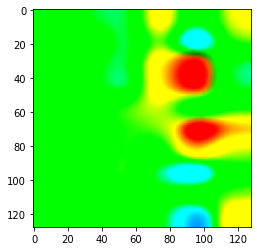

In [12]:
for num in range(len(tmpLabel)):
    if tmpLabel[num]==0:
        plt.imshow(tmpData[num][:], cmap='gray')
        print(tmpLabel[num])
        break

1


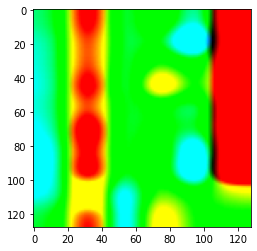

In [13]:
# how feature graph look like
for num in range(len(tmpLabel)):
    if tmpLabel[num]==1:
        plt.imshow(tmpData[num], cmap='gray')
        print(tmpLabel[num])
        break

2


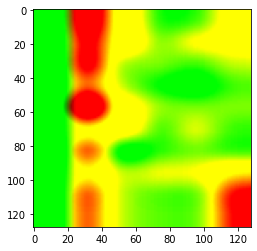

In [14]:
# how feature graph look like
for num in range(len(tmpLabel)):
    if tmpLabel[num]==2:
        plt.imshow(tmpData[num], cmap='gray')
        print(tmpLabel[num])
        break

In [15]:
#Number of each category
numofclass0=0
numofclass1=0
numofclass2=0
for num in range(len(tmpLabel)):
    if tmpLabel[num]==0:
        numofclass0+=1
    elif tmpLabel[num]==1:
        numofclass1+=1
    elif tmpLabel[num]==2:
        numofclass2+=1
print(numofclass0,"->",numofclass0/len(tmpLabel))
print(numofclass1,"->",numofclass1/len(tmpLabel))
print(numofclass2,"->",numofclass2/len(tmpLabel))

35020 -> 0.7893609827566775
5766 -> 0.12996731657838387
3579 -> 0.08067170066493858


In [16]:
tStart = time.time()

# shuffle, seed = 6
random.Random(6).shuffle(tmpData)
random.Random(6).shuffle(tmpLabel)

print("Shuffle complete.")

tmpData = np.array(tmpData)
tmpLabel = np.array(tmpLabel)

print("Transfer complete.")

trainingData, validData, trainingLabel, validLabel = train_test_split(tmpData, tmpLabel,test_size=0.125)

print("Split data complete.")


trainingData = trainingData.reshape(len(trainingData), 128,128, channel)
trainingLabel = trainingLabel.reshape(len(trainingLabel), 1)
# print(trainingData)
validData = validData.reshape(len(validData), 128,128, channel)
validLabel = validLabel.reshape(len(validLabel), 1)

print("Reshape data complete.")

trainingLabelOneHot = np_utils.to_categorical(trainingLabel) # One-Hot encoding label
validLabelOneHot = np_utils.to_categorical(validLabel)

tEnd = time.time()

print(f"\nPrepare training data complete in {tEnd - tStart} seconds.\n")

Shuffle complete.
Transfer complete.
Split data complete.
Reshape data complete.

Prepare training data complete in 6.791315317153931 seconds.



In [17]:
from keras import backend as K
K.image_data_format() == "channels_first"

tStart = time.time()

model = Sequential()

model.add(Conv2D(filters=36, kernel_size=(9, 9), activation='relu', input_shape=(128,128, channel)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=36, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=36, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128, activation = 'relu'))
model.add(Dense(units=3, activation = 'softmax')) # 3 labels

model.summary()

# sgd = Adam(lr=0.0005)

model.compile(loss = 'categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

tEnd = time.time()

print(f"\nBuild model complete in {tEnd - tStart} seconds.\n")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 36)      8784      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 36)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 36)        32436     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 36)        11700     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 36)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 36)        0

In [18]:
# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-06-27T14:54:00.001214Z","iopub.execute_input":"2021-06-27T14:54:00.001530Z","iopub.status.idle":"2021-06-27T14:54:00.759721Z","shell.execute_reply.started":"2021-06-27T14:54:00.001500Z","shell.execute_reply":"2021-06-27T14:54:00.758520Z"}}
def validDataGenerator(data, label, batch_size):
    
    # 分批載入資料，每批數量為batch_size
    
    i = 0
    
    while (True):
        
        yield data[i*batch_size : (i+1)*batch_size], label[i*batch_size : (i+1)*batch_size]
        
        if(i < len(label)//batch_size):
            i += 1
        else:
            i = 0

trainingDataGenerator = ImageDataGenerator(
#                             rotation_range=15,
#                             height_shif t_range=0.1,
#                             width_shift_range=0.05,
#                             horizontal_flip=True,
#                             vertical_flip=True,
#                             zoom_range=0.1,
                            data_format='channels_last'
)

trainingDataGenerator.fit(trainingData)

# %% [code] {"jupyter":{"outputs_hidden":false},"execution":{"iopub.status.busy":"2021-06-27T14:54:00.762312Z","iopub.execute_input":"2021-06-27T14:54:00.762631Z"}}
tStart = time.time()

batch_size = 128
epochs = 50

reduce_lr_from_loss = ReduceLROnPlateau(
#     factor = 0.95,
    factor = 0.7,
    monitor = 'val_loss',
    min_lr = 1e-6,
    patience = 4,
    verbose = 1,
)

reduce_lr_from_acc = ReduceLROnPlateau(
#     factor = 0.98,
    factor = 0.8,
    monitor = 'val_accuracy',
    min_lr = 1e-6,
    patience = 4,
    verbose = 1,
)

train_history = model.fit_generator(trainingDataGenerator.flow(trainingData, trainingLabelOneHot, batch_size),
    steps_per_epoch=len(trainingLabelOneHot)//batch_size,
    epochs=epochs,
    validation_data=validDataGenerator(validData, validLabelOneHot, batch_size),
    validation_steps=len(validLabelOneHot)//batch_size,
    verbose=1,
    callbacks=[reduce_lr_from_loss, reduce_lr_from_acc],
#     initial_epoch=75
)

tEnd = time.time()

print(f"\nTrain model complete in {tEnd - tStart} seconds.\n")

C:\Users\andy1\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
303/303 [==============================] - 67s 154ms/step - loss: 7.3959 - accuracy: 0.7375 - val_loss: 0.6348 - val_accuracy: 0.7885
Epoch 2/50
303/303 [==============================] - 45s 150ms/step - loss: 0.6361 - accuracy: 0.7859 - val_loss: 0.6318 - val_accuracy: 0.7902
Epoch 3/50
303/303 [==============================] - 44s 146ms/step - loss: 0.6193 - accuracy: 0.7909 - val_loss: 0.6187 - val_accuracy: 0.7911
Epoch 4/50
303/303 [==============================] - 46s 153ms/step - loss: 0.6047 - accuracy: 0.7936 - val_loss: 0.6107 - val_accuracy: 0.7903
Epoch 5/50
303/303 [==============================] - 44s 144ms/step - loss: 0.9923 - accuracy: 0.7859 - val_loss: 0.6209 - val_accuracy: 0.7898
Epoch 6/50
303/303 [==============================] - 46s 151ms/step - loss: 0.6153 - accuracy: 0.7919 - val_loss: 0.6179 - val_accuracy: 0.7898
Epoch 7/50
303/303 [==============================] - 43s 141ms/step - loss: 0.6164 - accuracy: 0.7938 - val_loss: 0.6060 - val_ac

303/303 [==============================] - 178s 587ms/step - loss: 0.1022 - accuracy: 0.9608 - val_loss: 1.2540 - val_accuracy: 0.7987

Epoch 00048: ReduceLROnPlateau reducing learning rate to 6.77021307637915e-06.
Epoch 49/50
303/303 [==============================] - 168s 554ms/step - loss: 0.1078 - accuracy: 0.9584 - val_loss: 1.2574 - val_accuracy: 0.7987
Epoch 50/50
303/303 [==============================] - 179s 590ms/step - loss: 0.1066 - accuracy: 0.9598 - val_loss: 1.2601 - val_accuracy: 0.7983

Train model complete in 4489.287974357605 seconds.



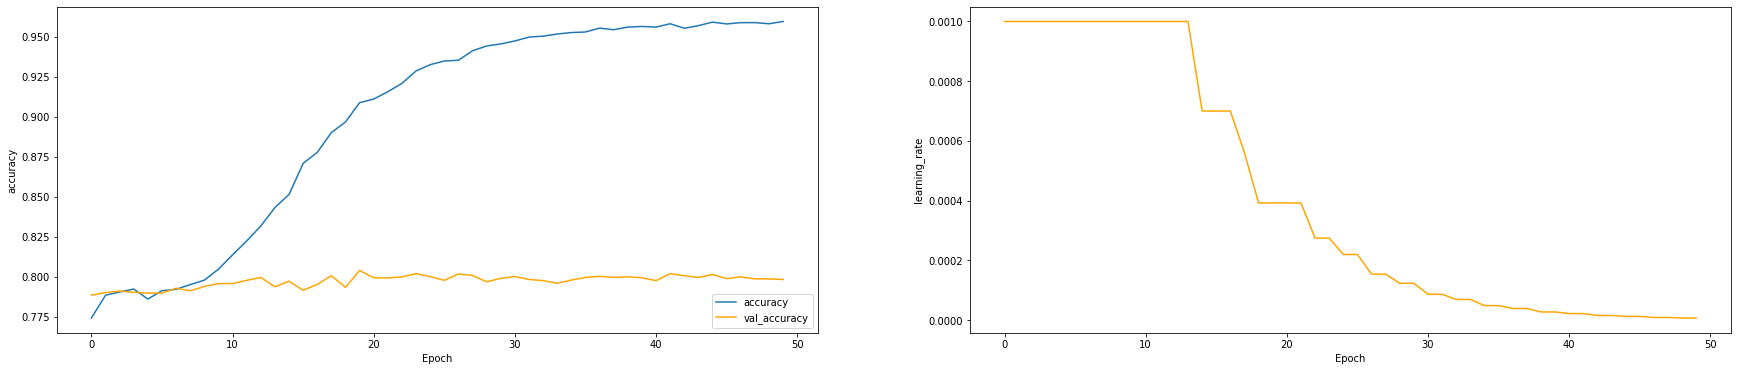

save done


C:\Users\andy1\AppData\Roaming\Python\Python38\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predict,0,1,2
label,,,
0,4081,225,66
1,499,188,48
2,232,47,160


In [19]:
# %% [code] {"jupyter":{"outputs_hidden":false}}
plt.figure(figsize=(30, 6))

plt.subplot(1, 2, 1)
plt.plot(train_history.history['accuracy'], label="accuracy")
plt.plot(train_history.history['val_accuracy'], 'orange', label="val_accuracy")
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')

# plt.subplot(1, 3, 2)
# plt.plot(train_history.history['loss'], label="loss")
# plt.plot( plt.xlabel('Epoch')
# plt.ylabel('loss')
# plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(train_history.history['lr'], 'orange')
plt.xlabel('Epoch')
plt.ylabel('learning_rate')

# plt.savefig("DefectDetecting-2.png")
plt.show()

# %% [code] {"jupyter":{"outputs_hidden":false}}
model.save('/kaggle/working/spesis-class3-v1.h5')
print("save done")

# %% [code] {"jupyter":{"outputs_hidden":false}}
import pandas as pd

prediction = model.predict_classes(validData)

pd.crosstab(validLabel.reshape(len(validLabel)), prediction, rownames=['label'], colnames=['predict'])